In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d


/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [92]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_296/func_0/'

In [93]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle = {}
for angle in [0,180]:
    starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
starts_angle_ms = {}
for angle in [0,180]:
    starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

loading photodiode data... done
Loaded from Pickle.
Found 749 presented stimuli.
starts_angle_0: 248. starts_angle_180: 248


In [64]:
ids_0 = np.zeros((len(starts_angle_ms[0])))
ids_180 = np.ones((len(starts_angle_ms[180])))
ids = np.concatenate((ids_0, ids_180))

In [18]:
#ids

In [11]:
times_ = np.concatenate((starts_angle_ms[0], starts_angle_ms[180]))

In [12]:
times_[0], times_[374]

(62580, 64630)

In [18]:
big_pool[2]

0.0

In [13]:
times_sorted = np.sort(times_)

In [14]:
times_sorted[0]

62580

In [15]:
np.where(76880 == 76880)

(array([0]),)

In [16]:
turn_ornot = []
for i in range(len(ve_turn_times[0])):
    turn_ornot.append(np.where(ve_turn_times[0][i] == times_sorted)[0][0])
    

In [26]:
i=0
np.where(ve_turn_times[0][i] == times_sorted)[0][0]

7

In [19]:
big_pool[turn_ornot]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [48]:
#r_s

In [135]:
#turn_ornot

In [20]:
len(turn_ornot)

53

In [21]:
wrong_turn = [i for i in r_s if i not in turn_ornot]
len(wrong_turn)

NameError: name 'r_s' is not defined

In [133]:
#ve_turn_times[0]

In [147]:
len(r_s)

374

In [134]:
#np.sort(times_)

In [17]:
big_pool = ids[np.argsort(times_)]
#big_pool

# argsort()
# Returns the indices that would sort an array.
# Perform an indirect sort along the given axis using the algorithm specified by the kind keyword. 
# It returns an array of indices of the same shape as a that index data along the given axis in sorted order.

In [4]:
#np.where(np.asarray(angles)==180)

In [91]:
# result = starts_angle_ms.items()
# result
# data = list(result)
# numpyArray = np.array(data)
# numpyArray

In [94]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [95]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300

behavior_traces = {}
mean_trace = {}
sem_trace = {}
for angle in [0,180]:
    behavior_traces[angle],mean_trace[angle],sem_trace[angle] = brainsss.extract_traces(fictrac,
                                                                                        starts_angle[angle],
                                                                                        pre_window,
                                                                                        post_window)
# scipy.stats.sem: Compute standard error of the mean

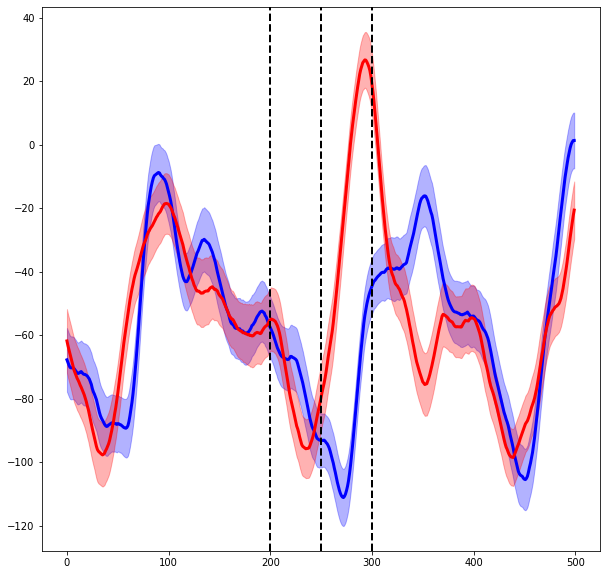

In [96]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    plt.plot(mean_trace[angle],color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_trace[angle])),mean_trace[angle]-sem_trace[angle], mean_trace[angle]+sem_trace[angle], color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

In [97]:
#####################################
### Extract Visually Evoked Turns ###
#####################################

ve_turns = {}
ve_turn_times = {}
for angle,direction in zip([0,180],['neg','pos']):
    
    mean_turn = mean_trace[angle]
    
#     if angle == 0:
#         mean_turn*=-1
    
    ve_turns[angle], ve_turn_times[angle] = brainsss.get_visually_evoked_turns(behavior_traces[angle],
                                                                      mean_turn,         
                                                                      start=250, 
                                                                      stop=300, 
                                                                      r_thresh=.3, 
                                                                      av_thresh=50, 
                                                                      stim_times=starts_angle_ms[angle],
                                                                      expected_direction=direction)
### what is ve_turns?
# ve_turns[0] is a matrix of behavior trace of right turn responding to right stimulus.
### what is ve_turn_times?
# ve_turn_times is a vector of time when the turning behavior is triggered by the stimulus.

In [49]:
#ve_turn_times[0]

In [68]:
#starts_angle_ms[0]

In [75]:
np.shape(ve_turns[0][1])

(500,)

In [76]:
np.shape(l_s)

(374,)

In [14]:
ve_turns[0].shape, ve_turns[180].shape

((53, 500), (25, 500))

In [71]:
#ve_turn_times[0]

In [ ]:
# def get_visually_evoked_turns(traces, mean_turn, start, stop, r_thresh, av_thresh, stim_times, expected_direction):
#     ### this will flip the sign of the trace to get the correct av_thresh comparison
#     if expected_direction == 'pos':
#         flip = 1
#     elif expected_direction == 'neg':
#         flip = -1


#     mean_trace = mean_turn[start:stop] * flip * -1
    
#     ### calculate correlation of each turn to mean turn within a defined window
#     rs = []
#     for i in range(traces.shape[0]):
#         rs.append(scipy.stats.pearsonr(mean_trace, traces[i,start:stop])[0])
    
#     turns = []
#     stim_evoked_turn_times = []
#     for i in range(traces.shape[0]):
#         if rs[i]>r_thresh:
#             if max(traces[i,start:stop]*flip) > av_thresh:
#                 turns.append(traces[i,:])
#                 stim_evoked_turn_times.append(stim_times[i])
#     turns = np.asarray(turns)
#     return turns, stim_evoked_turn_times

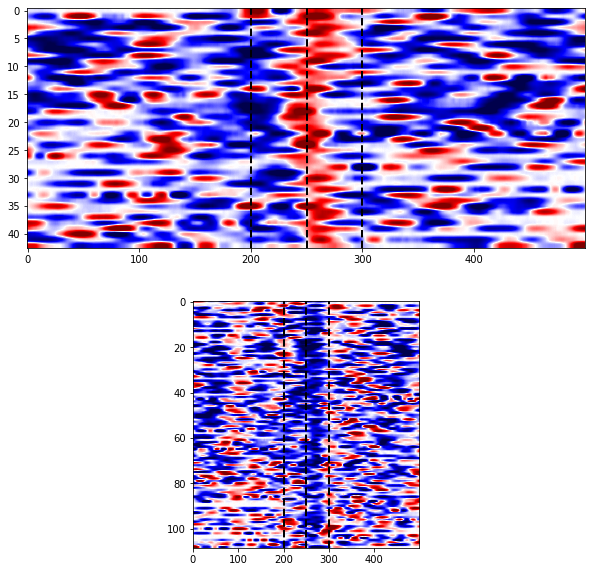

In [98]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

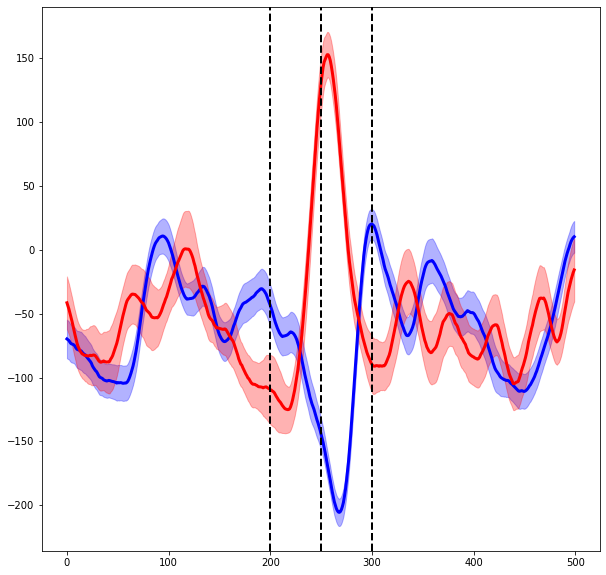

In [99]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    
    plt.axvline(line,color='k',linestyle='--',lw=2)

In [ ]:
############################### Markov Chain ###########################

# Four conditions:
# turn left with left stimulus (turn_180)
# turn right with right stimus (turn_0)
# turn left or no turn with left stimus (wrong_180turn)
# turn right or no turn with right stimus (wrong_0turn)

### Find vestors of the 4 conditions ###
 # Index vestors with left stimulus and Index vectors with right stimus 
    # (l_s, r_s)
 # filter the index vectors with ve_trun to generate LY,LN,RY,RN. 
    #(turn_180,turn_0,wrong_180turn, wrong_0turn)
 # Find the following vectors. (i+1) from the previous step.

### Probability of having one of the 4 conditions ###
 # num of LY(of i+1)/ num of total LY (of i+1)
 # num of LN(of i+1)/ num of total LY (of i+1)
 # num of RY(of i+1)/ num of total LY (of i+1)
 # num of RN(of i+1)/ num of total LY (of i+1)
### Transition Matrix ###
 # repeat the probability step 4 times to generate the matrix
### 0,right turn, negative; 
### 180,left turn, positive

In [100]:
########
ids_0 = np.zeros((len(starts_angle_ms[0]))) # timestamps of stimulus starts from 0 turned into 0
ids_180 = np.ones((len(starts_angle_ms[180])))# timestamps of stimulus starts from 0 turned into 1
ids = np.concatenate((ids_0, ids_180)) # concatenate ids_0 and ids_180, all 0 or 1 NOT sorted

times_ = np.concatenate((starts_angle_ms[0], starts_angle_ms[180])) # specific timestamps (not 0 or 1)

times_sorted = np.sort(times_)# sorted based on the value. Specific timestamps (not 0 or 1)

big_pool = ids[np.argsort(times_)] #0 or 1 based on their specific timestamp values
#big_pool

# argsort()
# Returns the indices that would sort an array.
# Perform an indirect sort along the given axis using the algorithm specified by the kind keyword. 
# It returns an array of indices of the same shape as a that index data along the given axis in sorted order.

### index vectors of right stimulus: r_s
### index vectors of left stimulus: l_s
r_s =[] # len = 374
l_s =[] # len = 374
for i in range(len(big_pool)):
    if big_pool[i] == 0:
        r_s.append(i)
    else:
        l_s.append(i)

### index vector of right stimulus with right turn: turn_0
### index vector of left stimulus with left turn: turn_180
turn_0 = [] # len = 53
for i in range(len(ve_turn_times[0])):
    turn_0.append(np.where(ve_turn_times[0][i] == times_sorted)[0][0])
turn_180 = [] # len = 25
for i in range(len(ve_turn_times[180])):
    turn_180.append(np.where(ve_turn_times[180][i] == times_sorted)[0][0])
    
### index vector of right stimulus without right turn: wrong_0turn
### index vector of left stimulus without left turn: wrong_180turn    
wrong_0turn = [i for i in r_s if i not in turn_0] # len = 321
wrong_180turn= [i for i in l_s if i not in turn_180] # len = 349

In [101]:
Prob_ry= len(turn_0)/len(r_s)
Prob_ly= len(turn_180)/len(l_s)
Prob_rn= len(wrong_0turn)/len(r_s)
Prob_ln= len(wrong_180turn)/len(l_s)

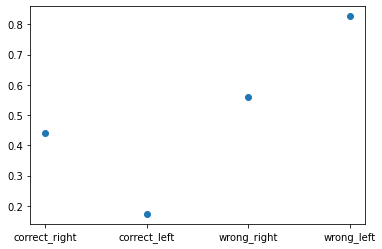

In [102]:
y= [Prob_ry,Prob_ly,Prob_rn,Prob_ln]
y = np.asarray(y)
x = ["correct_right","correct_left","wrong_right","wrong_left"]
plt.scatter(x,y)

In [121]:
turn_0
7 in turn_0

True

In [119]:
c = [2,3,4,5]
2 in c

True

In [152]:
turn_0[0] +1

8

In [103]:
### when the fly turn right correctly, what will the fly do next?
ryry = []
ryly = []
ryln = []
ryrn = []
for i in range(len(turn_0)):
    if turn_0[i]+1 in turn_0:
        ryry.append(turn_0[i]+1)
    elif turn_0[i]+1 in turn_180:
        ryly.append(turn_0[i]+1)
    elif turn_0[i]+1 in wrong_0turn:
        ryln.append(turn_0[i]+1)
    else:
        ryrn.append(turn_0[i]+1)
P_ryry = len(ryry)/len(turn_0)
P_ryly = len(ryly)/len(turn_0)
P_ryrn = len(ryrn)/len(turn_0)
P_ryln = len(ryln)/len(turn_0)


### when the fly turn r wrongly, what will the fly do next?
rnry = []
rnly = []
rnrn = []
rnln = []
for i in range(len(wrong_0turn)):
    if wrong_0turn[i]+1 in turn_0:
        rnry.append(wrong_0turn[i]+1)
    elif wrong_0turn[i]+1 in turn_180:
        rnly.append(wrong_0turn[i]+1)
    elif wrong_0turn[i]+1 in wrong_0turn:
        rnln.append(wrong_0turn[i]+1)
    else:
        rnrn.append(wrong_0turn[i]+1)
P_rnry = len(rnry)/len(wrong_0turn)
P_rnly = len(rnly)/len(wrong_0turn)
P_rnrn = len(rnrn)/len(wrong_0turn)
P_rnln = len(rnln)/len(wrong_0turn)

### when the fly turn l correctly, what will the fly do next?
lyry = []
lyly = []
lyrn = []
lyln = []
for i in range(len(turn_180)):
    if turn_180[i]+1 in turn_0:
        lyry.append(turn_180[i]+1)
    elif turn_180[i]+1 in turn_180:
        lyly.append(turn_180[i]+1)
    elif turn_180[i]+1 in wrong_0turn:
        lyln.append(turn_180[i]+1)
    else:
        lyrn.append(turn_180[i]+1)
P_lyry = len(lyry)/len(turn_180)
P_lyly = len(lyly)/len(turn_180)
P_lyln = len(lyln)/len(turn_180)
P_lyrn = len(lyrn)/len(turn_180)

### when the fly turn l wrong, what will the fly do next?
lnry = []
lnly = []
lnrn = []
lnln = []
for i in range(len(wrong_180turn)):
    if wrong_180turn[i]+1 in turn_0:
        lnry.append(wrong_180turn[i]+1)
    elif wrong_180turn[i]+1 in turn_180:
        lnly.append(wrong_180turn[i]+1)
    elif wrong_180turn[i]+1 in wrong_0turn:
        lnln.append(wrong_180turn[i]+1)
    else:
        lnrn.append(wrong_180turn[i]+1)
P_lnry = len(lnry)/len(wrong_180turn)
P_lnly = len(lnly)/len(wrong_180turn)
P_lnrn = len(lnrn)/len(wrong_180turn)
P_lnln = len(lnln)/len(wrong_180turn)



In [104]:
P_ry = np.asarray([P_ryry, P_ryly,P_ryrn,P_ryln])
P_ly = np.asarray([P_lyry, P_lyly,P_lyrn ,P_lyln])
P_rn = np.asarray([P_rnry, P_rnly,P_rnrn,P_rnln])
P_ln = np.asarray([P_lnry, P_lnly,P_lnrn ,P_lnln])

In [105]:
G = [P_ry,P_ly,P_rn,P_ln]
G#296

[array([0.26605505, 0.01834862, 0.48623853, 0.2293578 ]),
 array([0.13953488, 0.11627907, 0.34883721, 0.39534884]),
 array([0.17266187, 0.14388489, 0.43884892, 0.24460432]),
 array([0.24390244, 0.07317073, 0.37560976, 0.30731707])]

In [91]:
F = [P_ry,P_ly,P_rn,P_ln]
F#294

[array([0.06666667, 0.1       , 0.56666667, 0.26666667]),
 array([0.2       , 0.06666667, 0.33333333, 0.4       ]),
 array([0.05045872, 0.02752294, 0.55963303, 0.36238532]),
 array([0.06008584, 0.02145923, 0.38197425, 0.53648069])]

In [76]:
E = [P_ry,P_ly,P_rn,P_ln]
E#292

[array([0.1641791 , 0.11940299, 0.40298507, 0.31343284]),
 array([0.06, 0.16, 0.5 , 0.28]),
 array([0.12707182, 0.0718232 , 0.38121547, 0.4198895 ]),
 array([0.14646465, 0.10606061, 0.39393939, 0.35353535])]

In [61]:
D= [P_ry,P_ly,P_rn,P_ln]
D#122

[array([0.05555556, 0.11111111, 0.77777778, 0.05555556]),
 array([0.2, 0. , 0.2, 0.6]),
 array([0.04285714, 0.05714286, 0.7       , 0.2       ]),
 array([0.14102564, 0.05128205, 0.17948718, 0.62820513])]

In [46]:
C = [P_ry,P_ly,P_rn,P_ln]
C#116

[array([0.        , 0.11111111, 0.66666667, 0.22222222]),
 array([0.        , 0.        , 0.28571429, 0.71428571]),
 array([0.03797468, 0.07594937, 0.65822785, 0.2278481 ]),
 array([0.07407407, 0.        , 0.27160494, 0.65432099])]

In [30]:
B = [P_ry,P_ly,P_rn,P_ln]
B#137

[array([0.02272727, 0.11363636, 0.61363636, 0.25      ]),
 array([0.14705882, 0.08823529, 0.17647059, 0.58823529]),
 array([0.02424242, 0.06363636, 0.69393939, 0.21818182]),
 array([0.08823529, 0.01470588, 0.23235294, 0.66470588])]

In [15]:
A = [P_ry,P_ly,P_rn,P_ln]
A#134

[array([0.0754717 , 0.        , 0.79245283, 0.13207547]),
 array([0.04, 0.08, 0.12, 0.76]),
 array([0.05607477, 0.0529595 , 0.66043614, 0.2305296 ]),
 array([0.08595989, 0.01719198, 0.26647564, 0.63037249])]

In [212]:
np.asarray(turn_180)

array([  3,  25,  32,  69,  79,  80, 105, 165, 186, 190, 216, 227, 234,
       274, 306, 311, 316, 439, 464, 560, 579, 648, 707, 708, 711])

In [215]:
np.asarray(turn_0)+1

array([  8,  13,  18,  22,  47,  65,  74,  76, 102, 107, 122, 129, 133,
       136, 137, 148, 150, 153, 161, 169, 179, 181, 184, 193, 204, 219,
       224, 257, 266, 269, 279, 285, 315, 322, 331, 371, 374, 375, 385,
       409, 413, 422, 423, 429, 433, 471, 478, 514, 518, 519, 585, 596,
       715])

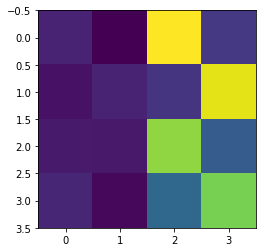

In [16]:
plt.imshow(A)

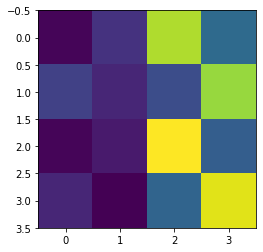

In [31]:
plt.imshow(B)

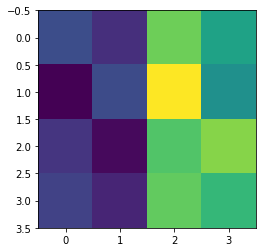

In [77]:
plt.imshow(E)

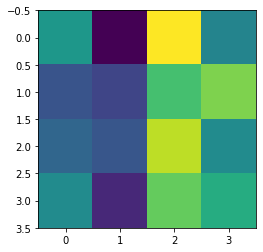

In [106]:
plt.imshow(G)

In [150]:
all_l = np.asarray(l_s)
all_l

array([  1,   3,   5,   6,   9,  10,  13,  15,  16,  18,  20,  22,  25,
        27,  28,  31,  32,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  54,  56,  59,  60,  63,  65,  66,  69,  71,  72,  74,  77,
        79,  80,  82,  85,  87,  88,  91,  92,  94,  97,  99, 100, 102,
       105, 107, 108, 111, 112, 115, 116, 119, 120, 123, 125, 127, 129,
       130, 133, 134, 137, 138, 140, 143, 145, 146, 148, 150, 153, 154,
       156, 158, 161, 162, 165, 166, 169, 171, 173, 175, 177, 179, 181,
       182, 184, 186, 189, 190, 193, 194, 197, 199, 201, 202, 205, 207,
       208, 210, 213, 214, 216, 219, 221, 222, 225, 227, 229, 231, 233,
       234, 237, 238, 241, 243, 244, 246, 249, 251, 253, 255, 257, 259,
       261, 262, 264, 266, 269, 271, 272, 274, 277, 279, 280, 282, 285,
       286, 288, 291, 293, 294, 297, 298, 301, 302, 305, 306, 309, 311,
       312, 315, 316, 319, 320, 322, 325, 327, 328, 331, 332, 335, 336,
       339, 340, 343, 345, 346, 348, 350, 352, 354, 356, 358, 36

In [145]:
a

array([  7,  12,  17,  21,  46,  64,  73,  75, 101, 106, 121, 128, 132,
       135, 136, 147, 149, 152, 160, 168, 178, 180, 183, 192, 203, 218,
       223, 256, 265, 268, 278, 284, 314, 321, 330, 370, 373, 374, 384,
       408, 412, 421, 422, 428, 432, 470, 477, 513, 517, 518, 584, 595,
       714])

In [165]:
rry

[136, 374, 422, 518]

In [109]:
b = np.asarray(wrong_0turn)
b

array([  0,   2,   4,   8,  11,  14,  19,  23,  24,  26,  29,  30,  33,
        34,  36,  38,  40,  42,  44,  48,  50,  52,  55,  57,  58,  61,
        62,  67,  68,  70,  76,  78,  81,  83,  84,  86,  89,  90,  93,
        95,  96,  98, 103, 104, 109, 110, 113, 114, 117, 118, 122, 124,
       126, 131, 139, 141, 142, 144, 151, 155, 157, 159, 163, 164, 167,
       170, 172, 174, 176, 185, 187, 188, 191, 195, 196, 198, 200, 204,
       206, 209, 211, 212, 215, 217, 220, 224, 226, 228, 230, 232, 235,
       236, 239, 240, 242, 245, 247, 248, 250, 252, 254, 258, 260, 263,
       267, 270, 273, 275, 276, 281, 283, 287, 289, 290, 292, 295, 296,
       299, 300, 303, 304, 307, 308, 310, 313, 317, 318, 323, 324, 326,
       329, 333, 334, 337, 338, 341, 342, 344, 347, 349, 351, 353, 355,
       357, 359, 361, 363, 364, 366, 368, 377, 378, 380, 383, 387, 389,
       391, 392, 394, 396, 398, 400, 402, 404, 407, 411, 415, 416, 418,
       425, 427, 431, 435, 436, 438, 440, 443, 444, 446, 449, 45

In [110]:
a = np.asarray(turn_0)
a

array([  7,  12,  17,  21,  46,  64,  73,  75, 101, 106, 121, 128, 132,
       135, 136, 147, 149, 152, 160, 168, 178, 180, 183, 192, 203, 218,
       223, 256, 265, 268, 278, 284, 314, 321, 330, 370, 373, 374, 384,
       408, 412, 421, 422, 428, 432, 470, 477, 513, 517, 518, 584, 595,
       714])

In [ ]:
for elem in r_s:
    if elem =

In [22]:
np.size(np.where(ve_turns[0]<0))

28564

In [23]:
np.where(ve_turns[0]<0)

(array([ 0,  0,  0, ..., 52, 52, 52]),
 array([  0,   1,   5, ..., 497, 498, 499]))

In [24]:
np.size(np.where(ve_turns[0]>=0))

24436

In [25]:
np.size(np.where(ve_turns[0]))

53000

In [26]:
np.size(np.where(starts_angle_ms[0]))

374

In [27]:
big_pool[4]

0.0

In [50]:
# l_s is the vector containing LEFT STIMULUS; 
# r_s is RIGHT STIMULUS
# l_s = np.where(starts_angle_ms[180])
# r_s = np.where(starts_angle_ms[0])

In [29]:
# r_s = np.zeros((len(starts_angle_ms[0])))
# l_s = np.zeros((len(starts_angle_ms[180])))

In [52]:
# r_s = np.flatten(r_s)
# type(r_s)

In [31]:
#r_s.flatten()

In [32]:
np.size(big_pool)

748

In [55]:
# r_s =[]
# l_s =[]
# for i in range(len(big_pool)):
#     if big_pool[i] == 0:
#         r_s.append(i)
#     else:
#         l_s.append(i)


In [57]:
#r_s

In [47]:
#big_pool

In [35]:
# bp_ve_turns = {}
# bp_ve_turn_times = {}
# for angle,direction in zip([0,180],['neg','pos']):
    
#     mean_turn = mean_trace[angle]
    
# #     if angle == 0:
# #         mean_turn*=-1
    
#     bp_ve_turns[angle], bp_ve_turn_times[angle] = brainsss.get_visually_evoked_turns(behavior_traces[angle],
#                                                                       mean_turn,         
#                                                                       start=250, 
#                                                                       stop=300, 
#                                                                       r_thresh=.3, 
#                                                                       av_thresh=50, 
#                                                                       stim_times=big_pool[angel],
#                                                                       expected_direction=direction)

NameError: name 'angel' is not defined

In [37]:
start_angle_all = np.concatenate(np.asarray(starts_angle_ms[180]),np.asarray(starts_angle_ms[0]))

TypeError: only integer scalar arrays can be converted to a scalar index

In [38]:
arr1 = np.array([1,2,3])
arr1

array([1, 2, 3])

In [39]:
#starts_angle_ms[180]

In [40]:
#starts_angle_ms[180]

In [41]:
# l_s

In [42]:
np.size(l_s)+np.size(r_s)

748

In [43]:
np.size(angles)
# why they do not equal to each other

753

In [44]:
# turn left or no turn with left stimus (LN)
# turn right or no turn with right stimus (RN)
### 0,right turn, negative; 
### 180,left turn, positive
RY = np.where(ve_turn_times[0]) # 53
LY = np.where(ve_turn_times[180])# 25

In [45]:
big_pool[RY]

array([0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0.])

In [46]:
# turn left or no turn with left stimus (LN)
# turn right or no turn with right stimus (RN)


In [58]:
r_s - np.intersect1d(RY,r_s)

ValueError: operands could not be broadcast together with shapes (1,374) (53,) 

In [27]:
def get_stimuli_where_no_behavior(traces, start, stop, num_traces_to_return, stim_times):
    amount_of_behavior = np.mean(np.abs(traces[:,start:stop]),axis=-1)
    indicies = np.argsort(amount_of_behavior)
    top_x_indicies = indicies[:num_traces_to_return]
    return traces[top_x_indicies,:], np.asarray(stim_times)[top_x_indicies]

In [28]:
ve_no_turns = {}
ve_no_turn_times = {}
for angle in [0,180]:
    ve_no_turns[angle], ve_no_turn_times[angle] = get_stimuli_where_no_behavior(behavior_traces[angle],
                                  start=250,
                                  stop=300,
                                  num_traces_to_return=len(ve_turns[angle]), # get the same number as ve_turns
                                  stim_times=starts_angle_ms[angle])

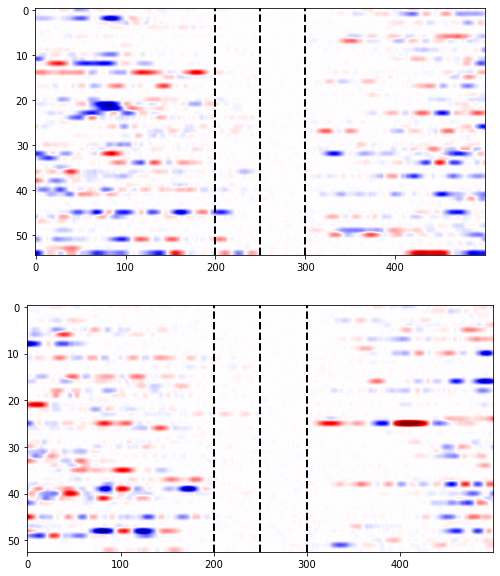

In [29]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_no_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_no_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

In [ ]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_no_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_no_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.ylim(-50,50)

In [ ]:
# Load Neural

In [ ]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [ ]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

In [ ]:
fixed = brainsss.load_fda_meanbrain()
atlas = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)